<a href="https://colab.research.google.com/github/dongjaeseo/colab/blob/main/medical_decathlon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# mount your drive if needed
from google.colab import drive
drive.mount('/content/drive')
DATA_ROOT = 'drive/MyDrive/medical_decathlon'

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install monai
!pip install datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 KB 28.1 MB/s eta 0:00:00


In [48]:
import numpy as np
import json
from datetime import datetime

import torch
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch import sigmoid


from monai.utils import set_determinism
from monai.transforms import (
    Compose,
    Lambdad,
    LoadImaged,
    AddChanneld,
    ScaleIntensityRanged,
    BorderPadd,
    RandCropByPosNegLabeld,
    RandRotated,
    RandZoomd,
    AsDiscreted,
    SelectItemsd,
    Resized,
    ToTensord,
    Resize
)
from monai.data import (
    Dataset, 
    CacheDataset, 
    DataLoader, 
    partition_dataset_classes
)
from monai.networks.nets import UNet, VNet
from monai.losses import DiceLoss
from monai.metrics import compute_meandice
from monai.inferers import SlidingWindowInferer

from tqdm import trange, tqdm
import matplotlib.pyplot as plt
def imshow(x):
    plt.imshow(x, cmap='gray')
    plt.show()

In [61]:
import os
datalist = []

image_list = os.listdir(f'{DATA_ROOT}/images/')
image_list.sort()
label_list = os.listdir(f'{DATA_ROOT}/mask/')
label_list.sort()

for i in range(len(image_list)):
    if image_list[i] in label_list:
        datalist.append(dict(image = f'images/{image_list[i]}', label = f'mask/{image_list[i]}'))

print(datalist)

[{'image': 'images/lung_001.nii.gz', 'label': 'mask/lung_001.nii.gz'}, {'image': 'images/lung_002.nii.gz', 'label': 'mask/lung_002.nii.gz'}, {'image': 'images/lung_003.nii.gz', 'label': 'mask/lung_003.nii.gz'}, {'image': 'images/lung_004.nii.gz', 'label': 'mask/lung_004.nii.gz'}, {'image': 'images/lung_005.nii.gz', 'label': 'mask/lung_005.nii.gz'}, {'image': 'images/lung_006.nii.gz', 'label': 'mask/lung_006.nii.gz'}, {'image': 'images/lung_007.nii.gz', 'label': 'mask/lung_007.nii.gz'}, {'image': 'images/lung_008.nii.gz', 'label': 'mask/lung_008.nii.gz'}, {'image': 'images/lung_010.nii.gz', 'label': 'mask/lung_010.nii.gz'}, {'image': 'images/lung_012.nii.gz', 'label': 'mask/lung_012.nii.gz'}, {'image': 'images/lung_013.nii.gz', 'label': 'mask/lung_013.nii.gz'}, {'image': 'images/lung_014.nii.gz', 'label': 'mask/lung_014.nii.gz'}, {'image': 'images/lung_015.nii.gz', 'label': 'mask/lung_015.nii.gz'}, {'image': 'images/lung_017.nii.gz', 'label': 'mask/lung_017.nii.gz'}, {'image': 'images/l

In [72]:
np.random.seed(42)
np.random.shuffle(datalist)
# ---- train:valid:test = 7:2:1

test_ls = datalist[:10]

In [115]:
# PREPROCESSING

valid_trans = Compose([
    Lambdad(
        keys=['image', 'label'],
        func=lambda p: f'{DATA_ROOT}/{p}'
    ),
    LoadImaged(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    # Spacing(..., pixdim=[3.0, 3.0, 3.0]),
    ScaleIntensityRanged(
        keys=['image'],
        a_min=-900, 
        a_max=300,
        b_min=0,
        b_max=1,
        clip=True
    ),
    ToTensord(
        keys=['image', 'label'],
    ),
    Resized(
        keys=['image', 'label'],
        spatial_size = (113,113,100)
        ),
])

test_ds = CacheDataset(
    test_ls, 
    transform=valid_trans, 
    num_workers=2, 
    cache_rate=1.0
)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=2)

/usr/local/lib/python3.9/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
Loading dataset: 100%|██████████| 10/10 [00:28<00:00,  2.84s/it]


torch.Size([1, 113, 113, 100])


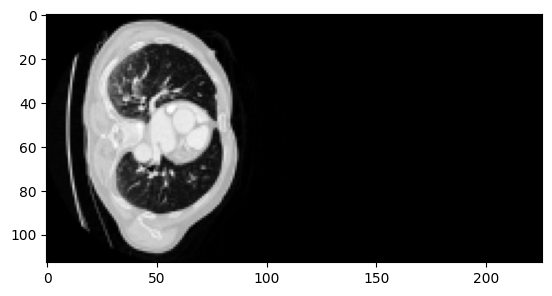

In [128]:
ls = test_ds[0]
print(ls['image'].shape)
image = ls['image']
label = ls['label']
D = image.shape[-1]
image = image[0, :, :, D//2]
label = label[0, :, :, D//2]*image.max()
imshow(np.hstack([image, label]))

In [129]:
set_determinism(42) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=[16, 32, 64],
    strides=[2, 2],
    num_res_units=0,
    dropout=0.0
).to(device)
'''
model = VNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.5,
    dropout_dim=3,
).to(device)
'''
loss = DiceLoss(sigmoid=True)
optimizer = Adam(model.parameters(), 1e-2)
infer = SlidingWindowInferer(
    roi_size=(64, 64, 64),
    sw_batch_size=8,
    overlap=0.25,
    mode='constant',
)

In [132]:
model.load_state_dict(torch.load('/content/drive/MyDrive/small_dataset/model.pt', map_location=torch.device('cpu')))
model.eval()

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Convolution(
            (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (adn): ADN(
              (N): InstanceNorm3d(64, eps=1e-05, momentum=

In [131]:
import torch
torch.cuda.empty_cache()

In [133]:
test_loss = 0
for batch in test_loader:
    labels = batch['label'].to(device)
    images = batch['image'].to(device)
    preds = infer(images, model)

    _loss = 1-compute_meandice(sigmoid(preds), labels)
    test_loss += _loss
test_loss /= len(test_loader)
print(f'test loss: {test_loss}')

/usr/local/lib/python3.9/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <function compute_meandice at 0x7fde30827af0>: Function `compute_meandice` has been deprecated since version 1.0.0. use `compute_dice` instead.
  warn_deprecated(obj, msg, warning_category)


test loss: tensor([[0.9984]], device='cuda:0', grad_fn=<AliasBackward0>)


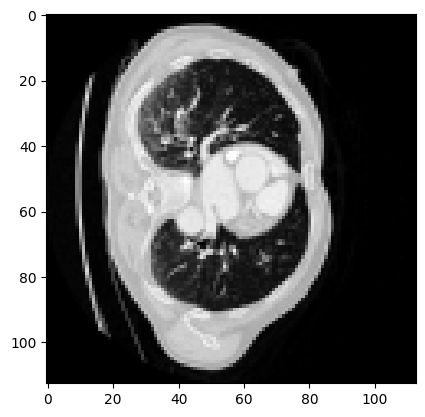

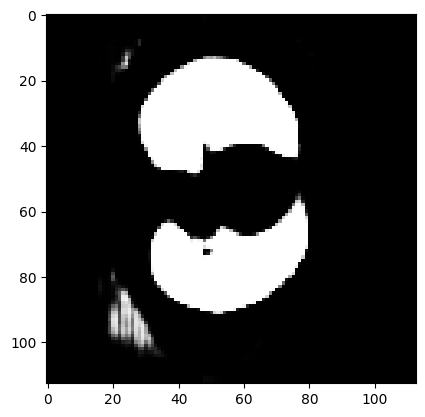

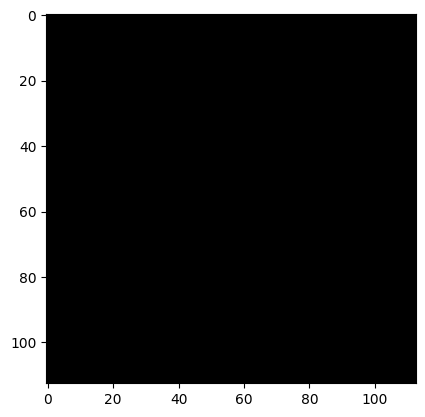

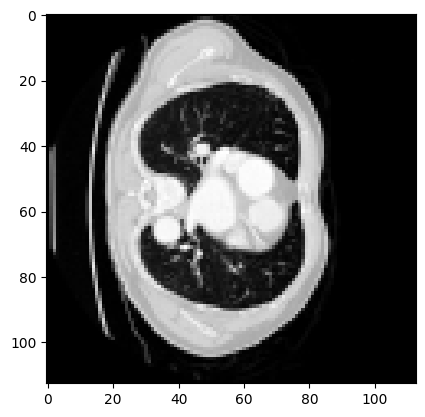

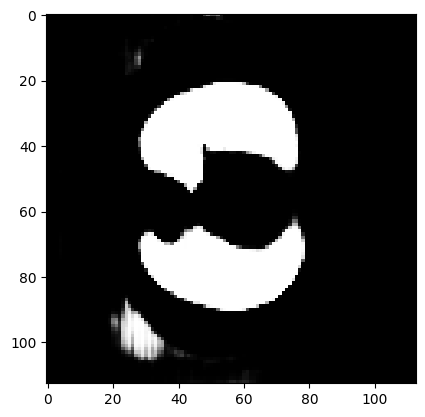

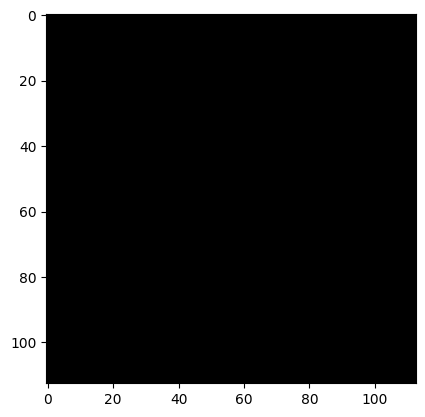

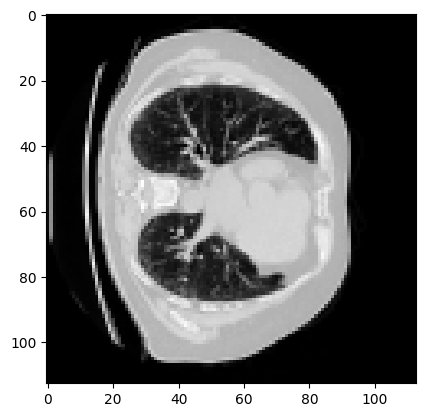

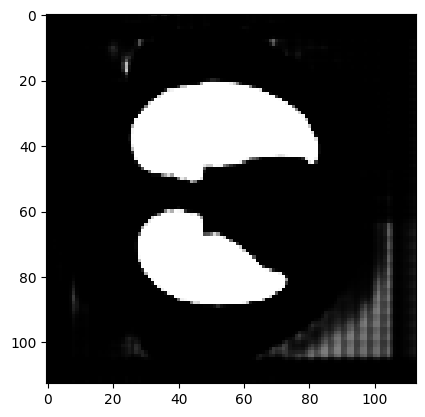

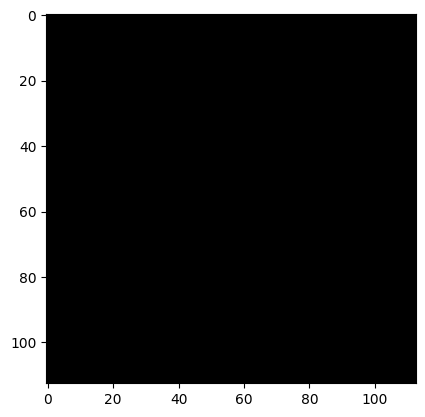

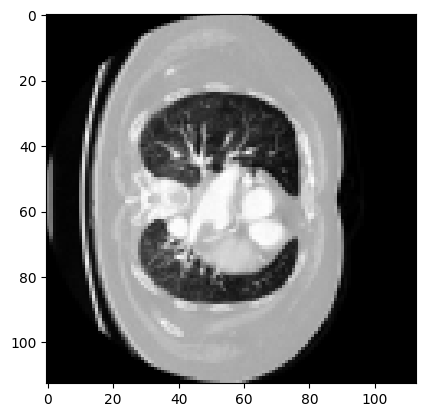

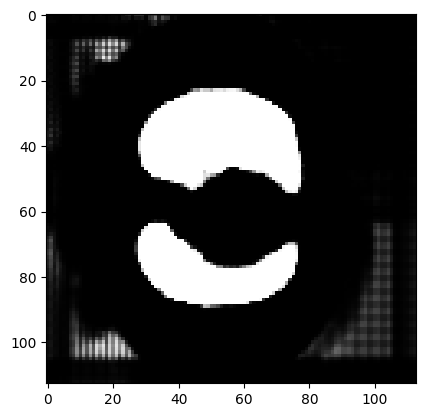

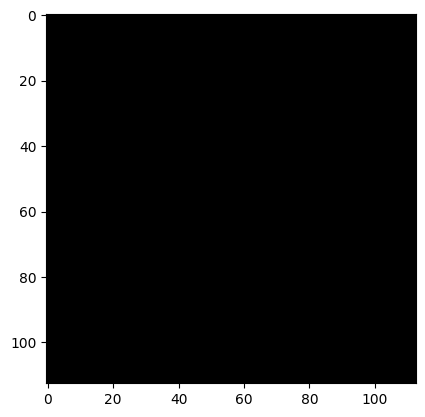

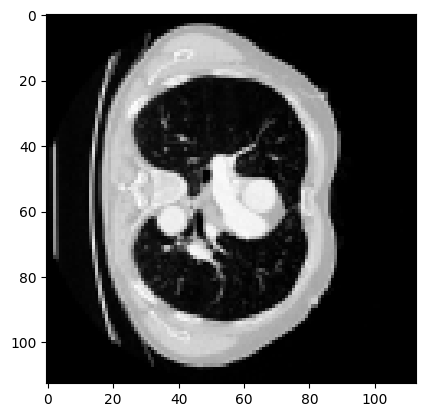

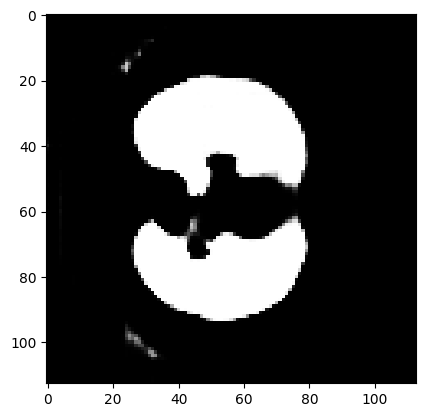

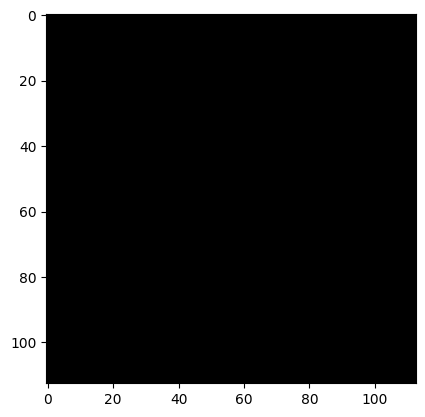

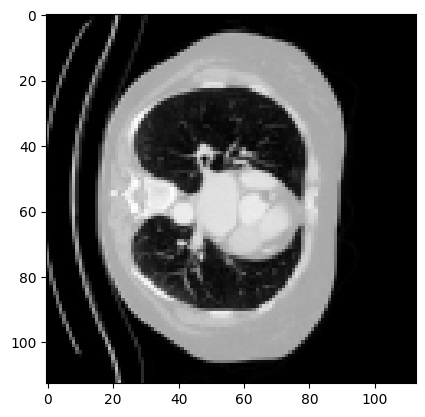

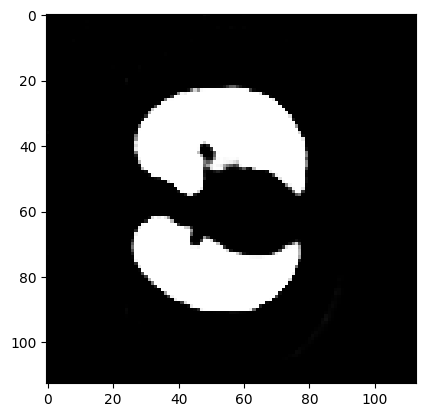

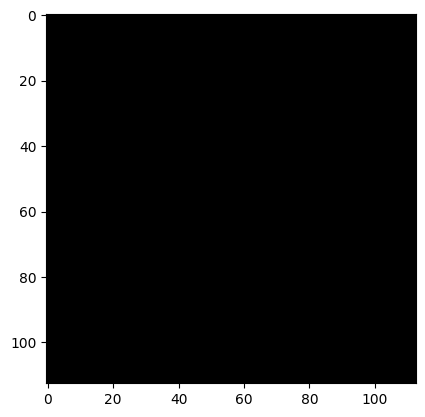

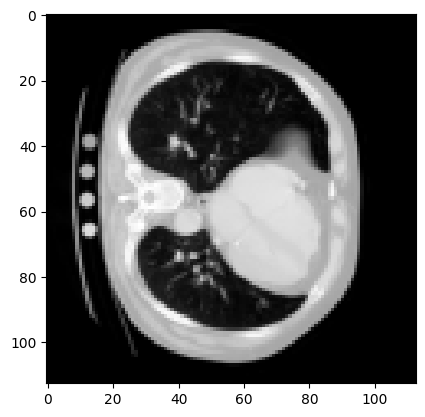

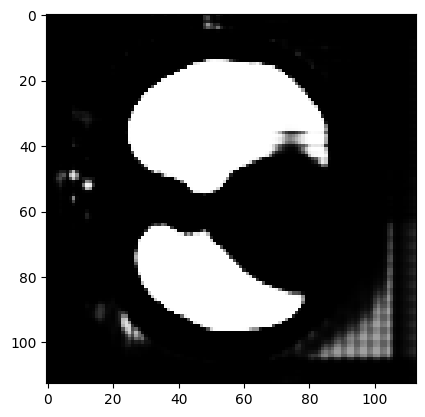

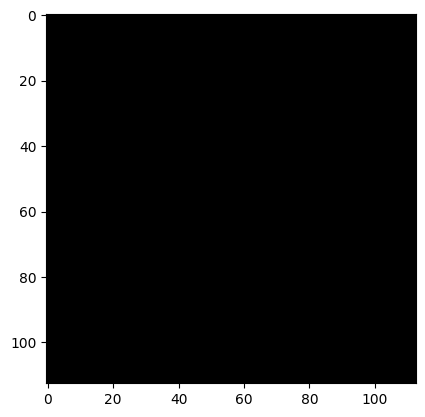

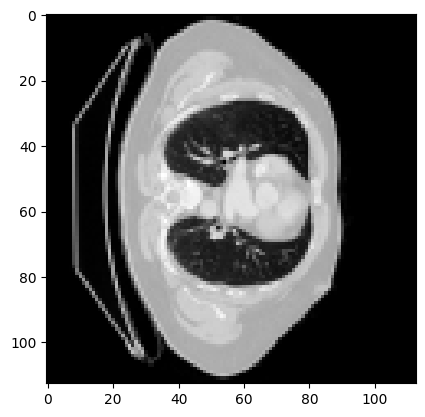

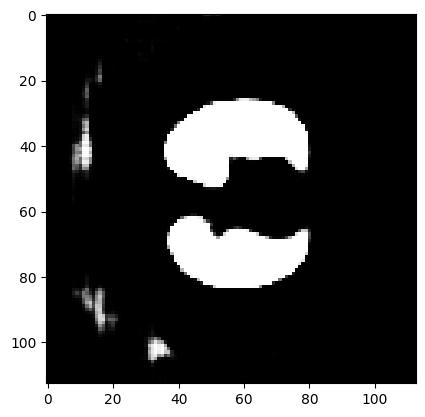

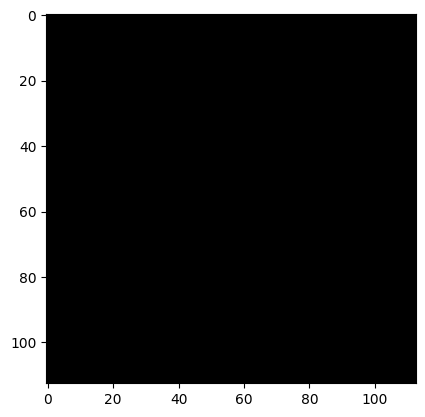

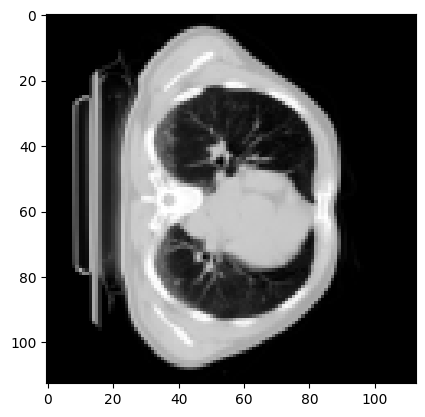

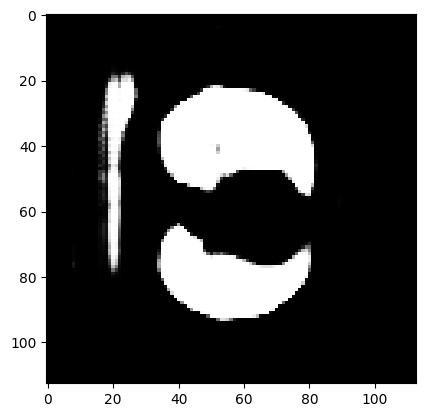

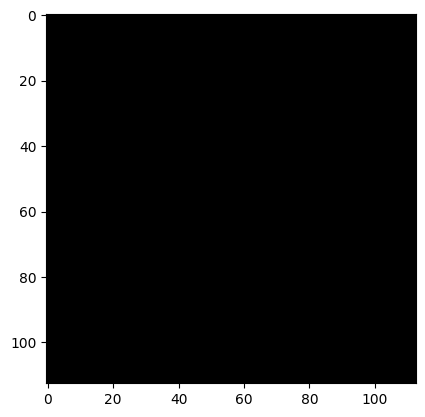

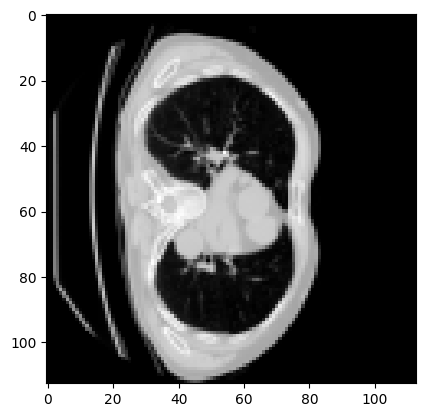

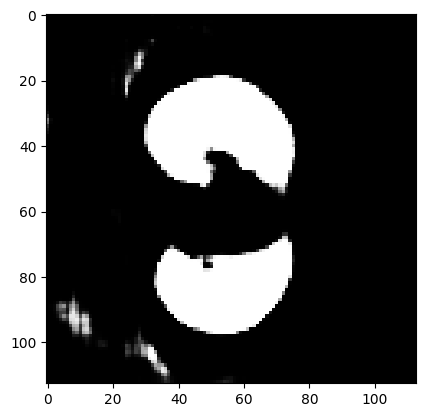

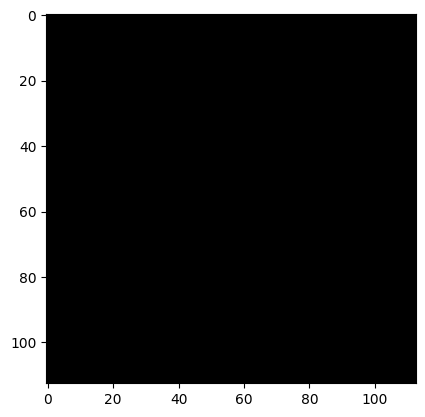

In [134]:
pred = sigmoid(preds).cpu().detach().numpy() # NCHWD

i = 0
for batch in test_loader:
    labels = batch['label'].to(device)
    images = batch['image'].to(device)
    preds = infer(images, model)

    pred = sigmoid(preds).cpu().detach().numpy()
    pred1 = pred[0]

    label = batch['label'][0]
    image = batch['image'][0]
    imshow(image[0,:,:,D//2])
    imshow(pred1[0,:,:,D//2])
    imshow(label[0,:,:,D//2])
    

    i+= 1

    if i == 10:
        break